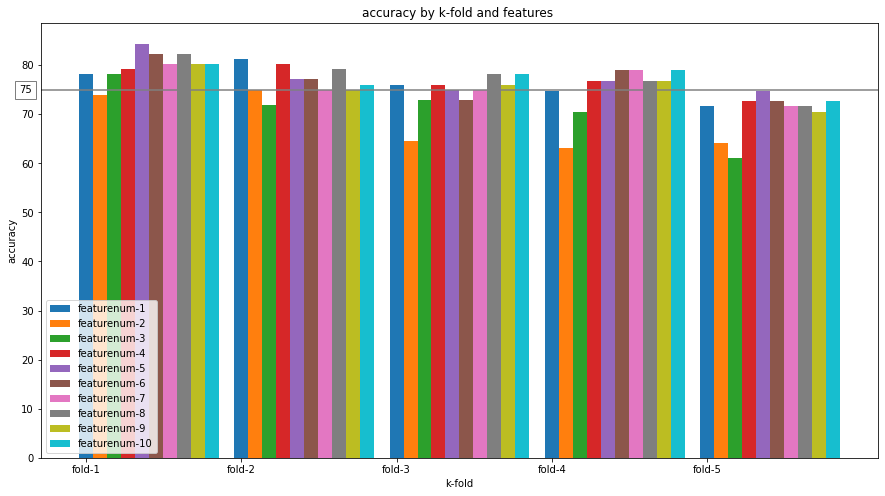

In [2]:
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from Logistic import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from random import choice
import numpy as np
from sklearn.model_selection import KFold
import heapq
import matplotlib.pyplot as plt
from numpy import *
from sklearn.ensemble import  ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier

"""
    使用随机森林进行分类
"""

def random_forest(feature_mat,labelMat):
    randomforest = RandomForestClassifier(n_estimators=200)
    randomforest.fit(feature_mat,labelMat)
    return randomforest

savepath = "D:/WorkSpace/Shell/DataMining/result/"
##加载数据
def loadCSVfile2(filepath,labelstr,featurestr):
    odata = pd.read_csv(filepath)
    label = odata[labelstr] ##不包括表头
    feature = odata.drop([featurestr], axis=1) #除去label列之外的所有feature值

    return np.array(label).reshape(-1), np.array(feature) #返回array类型的数据

##皮尔森系数
def pearsonFeature(feature, label):

    pearson = abs(np.corrcoef(feature.reshape(-1), label)[0][1])

    return pearson
##标准化
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

##处理Nan值
def handleNan(feature):

    contain_nan = (True in np.isnan(feature))
    if contain_nan is True:

        index_nan = 0
        for x in feature:##将nan替换为0或1
            if np.isnan(x):
                feature[index_nan] = choice([0, 1])
            index_nan += 1
    return feature

##对特征的异常值0进行处理，使用对应特征列的平均值进行填充
def handlErrorValue(feature_all, feature_select_num):
    feature_list = []
    pearson_list = []
    feature_pearson = []
    for index in range(16):
        feature = feature_all[:,index:1 + index]  #提取特征值列
        ##处理Nan特征值
        feature = handleNan(feature)


        feature_list.append(feature)
    return np.array(feature_list).T.reshape(-1, 16)

##保存结果报告文件
def save_to_file(file_name, contents):
    fh = open(file_name, 'w')
    fh.write(contents)
    fh.close()

##对五折结果进行柱状图的刻画
def histogramPicture(acc_all_list):
     # G1,G2,G3,G4,G5小组的分数。
    labels = ['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5']
    x = np.arange(len(labels))
    width = 0.09  # 柱形图的宽度
    plt.figure(figsize=(15, 8))
    plt.xticks(x, labels)  # 设置具体刻度。
    plt.xlabel('k-fold')  # x轴标签
    plt.ylabel('accuracy')  # y轴标签
    plt.title('accuracy by k-fold and features ')  # 该柱形图的标题
    num = 0
    for acc_list in acc_all_list:
        plt.bar(x + num * width, list(map(float, acc_list[0:5])), width,  label='featurenum-' + str(num + 1))  # 计算出左边柱形图的位置。
        num = num + 1

    plt.axhline(75, color="gray") #画出75%的线
    plt.text(-0.35, 75, "75", va='center', ha="right", bbox=dict(facecolor="w",alpha=0.5))##添加文字
    plt.legend()
    plt.savefig(savepath + "/picture/forest_acc.svg")
    plt.show()

def autolabel(ax,rects):
    """在每个柱形条上方添加一个文本标签，显示高度。"""
    index = 0
    for rect in rects:
        height = rect.get_height()  # 获取柱形条的高度。
        # annotate() 用于在图形上给数据添加文本注解(注释)。
        ax.annotate('{}'.format(height, ".2f"),  # s 注释文本内容
                    xy=(rect.get_x() + rect.get_width() * index, height),  # 被注释的坐标点：xy=(横坐标，纵坐标)，即每个柱形条的顶部中心。
                    xytext=(0, 3),  # 注释文本的坐标点（相对于被注释点取坐标）：xytext(横坐标，纵坐标)。
                    textcoords="offset points",  # 被注释点的坐标系属性：点，像素，百分比等。"offset points"指偏移量，单位：点。
                    ha='center')  # ha='center' 让注解居中
        index = index + 1

def mean(list):
    sum = 0
    for num in list:
        sum = float(num) + sum
    return format(sum/5, ".2f")
def kFoldGetResult(feature_all, label, feature_num, k_unm):

    accuracy_all_list = []
    for num in range(1,feature_num + 1):## 选择1-5个特征的数据情况下进行训练和测试
        feature_list= handlErrorValue(feature_all, num)
        kfold = KFold(n_splits = k_unm) #设立五折
        index = 0
        accuracy_list = []
        for train_index, test_index in kfold.split(feature_list): ##进行五折交叉实验
            ##提取训练数据和测试数据
            train_data, test_data = feature_list[train_index,:], feature_list[test_index,:]
            train_label, test_label = label[train_index], label[test_index]

            ##训练树来提取最好的特征
            clf = ExtraTreesClassifier(n_estimators=100)
            clf = clf.fit(train_data,train_label)
            model = SelectFromModel(clf,prefit=True, max_features=num)
            feature_new = model.transform(train_data)
            feature_test_new = model.transform(test_data)
            ##训练随机森林，并测试
            randomforest = random_forest(feature_new,train_label)
            pred = randomforest.predict(feature_test_new)
            accuracy = accuracy_score(test_label, pred)
            accuracy_list.append(format(accuracy * 100,".2f")) ##将五折准确率记录起来
            index = index + 1

        accuracy_list.append(mean(accuracy_list))
        accuracy_all_list.append(accuracy_list)  ##将选取不同特征得出的结果记录

    return accuracy_all_list

if __name__ == "__main__":
    ##加载数据
    label, feature_all = loadCSVfile2("train.csv", 'group', 'group')
    #进行5折交叉，将得到的准确率返回 特征个数从1-5
    acc_list = kFoldGetResult(feature_all, label, feature_num=10, k_unm=5)
    save_to_file(savepath + "acc/forest_acc.txt",str(acc_list))
    ##画出K折交叉的图
    histogramPicture(acc_list)




